In [1]:
import sklearn

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 

# MNIST is part of torchvision
from torchvision import datasets, transforms

In [4]:
import torchtuples as tt
from pycox.models import LogisticHazard
from pycox.utils import kaplan_meier
from pycox.evaluation import EvalSurv

In [5]:
# for reproducability
np.random.seed(1234)
_ = torch.manual_seed(1234)

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))]
)
mnist_train = datasets.MNIST('.', train=True, download=True,
                             transform=transform)
mnist_test = datasets.MNIST('.', train=False, transform=transform)

100.1%Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw
113.5%Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw
100.4%Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw
180.4%/home/liucj/github/TEP-prognosis/venv/lib/python3.6/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


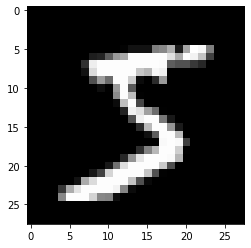

In [7]:
_ = plt.imshow(mnist_train[0][0][0].numpy(), cmap='gray')

In [8]:
def sim_event_times(mnist, max_time=700):
    digits = mnist.targets.numpy()
    betas = 365 * np.exp(-0.6 * digits) / np.log(1.2)
    event_times = np.random.exponential(betas)
    censored = event_times > max_time
    event_times[censored] = max_time
    return tt.tuplefy(event_times, ~censored)

In [9]:
sim_train = sim_event_times(mnist_train)
sim_test = sim_event_times(mnist_test)

In [10]:
sim_train

(array([ 21.19004682, 700.        , 104.56743096, ..., 121.80432849,
          2.50843078,  13.8114342 ]),
 array([ True, False,  True, ...,  True,  True,  True]))

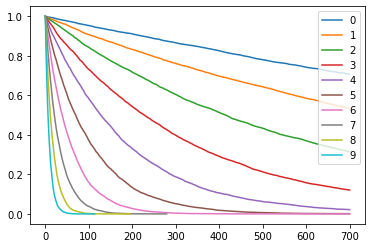

In [11]:
for i in range(10):
    idx = mnist_train.targets.numpy() == i
    kaplan_meier(*sim_train.iloc[idx]).rename(i).plot()
_ = plt.legend()

In [12]:
labtrans = LogisticHazard.label_transform(20)
target_train = labtrans.fit_transform(*sim_train)
target_test = labtrans.transform(*sim_test)

In [14]:
labtrans.cuts, target_train

(array([  0.        ,  36.84210526,  73.68421053, 110.52631579,
        147.36842105, 184.21052632, 221.05263158, 257.89473684,
        294.73684211, 331.57894737, 368.42105263, 405.26315789,
        442.10526316, 478.94736842, 515.78947368, 552.63157895,
        589.47368421, 626.31578947, 663.15789474, 700.        ]),
 (array([ 1, 19,  3, ...,  4,  1,  1]),
  array([1., 0., 1., ..., 1., 1., 1.], dtype=float32)))

## Make DataLoaders

In [15]:
class MnistSimDatasetSingle(Dataset):
    """Simulatied data from MNIST. Read a single entry at a time.
    """
    def __init__(self, mnist_dataset, time, event):
        self.mnist_dataset = mnist_dataset
        self.time, self.event = tt.tuplefy(time, event).to_tensor()

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        if type(index) is not int:
            raise ValueError(f"Need `index` to be `int`. Got {type(index)}.")
        img = self.mnist_dataset[index][0]
        return img, (self.time[index], self.event[index])

In [16]:
dataset_train = MnistSimDatasetSingle(mnist_train, *target_train)
dataset_test = MnistSimDatasetSingle(mnist_test, *target_test)

In [17]:
samp = tt.tuplefy(dataset_train[1])
samp.shapes()

(torch.Size([1, 28, 28]), (torch.Size([]), torch.Size([])))

In [19]:
def collate_fn(batch):
    """Stacks the entries of a nested tuple"""
    return tt.tuplefy(batch).stack()

In [20]:
batch_size = 128

In [21]:
dl_train = DataLoader(dataset_train, batch_size, shuffle=True, collate_fn=collate_fn)
dl_test = DataLoader(dataset_test, batch_size, shuffle=True, collate_fn= collate_fn)

In [22]:
batch = next(iter(dl_train))
batch.shapes()

(torch.Size([128, 1, 28, 28]), (torch.Size([128]), torch.Size([128])))

In [23]:
batch.dtypes()

(torch.float32, (torch.int64, torch.float32))

In [24]:
class MnistSimDatasetBatch(Dataset):
    def __init__(self, mnist_dataset, time, event):
        self.mnist_dataset = mnist_dataset
        self.time, self.event = tt.tuplefy(time, event).to_tensor()

    def __len__(self):
        return len(self.time)

    def __getitem__(self, index):
        if not hasattr(index, '__iter__'):
            index = [index]
        img = [self.mnist_dataset[i][0] for i in index]
        img = torch.stack(img)
        return tt.tuplefy(img, (self.time[index], self.event[index]))

In [25]:
dataset_train = MnistSimDatasetBatch(mnist_train, *target_train)
dataset_test = MnistSimDatasetBatch(mnist_test, *target_test)

In [26]:
samp = dataset_train[[0, 1, 3]]
samp.shapes()

(torch.Size([3, 1, 28, 28]), (torch.Size([3]), torch.Size([3])))

In [27]:
dl_train = tt.data.DataLoaderBatch(dataset_train, batch_size, shuffle=True)
dl_test = tt.data.DataLoaderBatch(dataset_test, batch_size, shuffle=False)

In [28]:
batch = next(iter(dl_train))
batch.shapes()

(torch.Size([128, 1, 28, 28]), (torch.Size([128]), torch.Size([128])))

In [29]:
batch.dtypes()

(torch.float32, (torch.int64, torch.float32))

In [30]:
class Net(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1)
        self.max_pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 16, 5, 1)
        self.glob_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(16, 16)
        self.fc2 = nn.Linear(16, out_features)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.glob_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [31]:
net = Net(labtrans.out_features)
net

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (glob_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=20, bias=True)
)

In [32]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

/home/liucj/github/TEP-prognosis/venv/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [33]:
pred = model.predict(batch[0])
pred.shape

torch.Size([128, 20])

In [34]:
callbacks = [tt.cb.EarlyStopping(patience=5)]
epochs = 50
verbose = True
log = model.fit_dataloader(dl_train, epochs, callbacks, verbose, val_dataloader=dl_test)

0:	:29s / 6m:29s],		train_loss: 2.0830,	val_loss: 1.8950
1:	:12s / 12m:41s],		train_loss: 1.8571,	val_loss: 1.8189
2:	:11s / 18m:53s],		train_loss: 1.8023,	val_loss: 1.7763
3:	:29s / 24m:23s],		train_loss: 1.7758,	val_loss: 1.7767
4:	:46s / 30m:9s],		train_loss: 1.7573,	val_loss: 1.7408
5:	:31s / 35m:40s],		train_loss: 1.7500,	val_loss: 1.7316
6:	:36s / 42m:17s],		train_loss: 1.7414,	val_loss: 1.7180
7:	:24s / 49m:41s],		train_loss: 1.7344,	val_loss: 1.7133
8:	:56s / 56m:37s],		train_loss: 1.7261,	val_loss: 1.7281
9:	:19s / 1h:2m:56s],		train_loss: 1.7217,	val_loss: 1.7111
10:	:0s / 1h:8m:57s],		train_loss: 1.7164,	val_loss: 1.7050
11:	:1s / 1h:14m:59s],		train_loss: 1.7119,	val_loss: 1.7027
12:	:43s / 1h:24m:42s],		train_loss: 1.7082,	val_loss: 1.7476
13:	:0s / 1h:32m:43s],		train_loss: 1.7080,	val_loss: 1.6948
14:	:5s / 1h:39m:49s],		train_loss: 1.7037,	val_loss: 1.6963
15:	:43s / 1h:46m:32s],		train_loss: 1.7017,	val_loss: 1.6974
16:	:18s / 1h:52m:50s],		train_loss: 1.7005,	val_loss

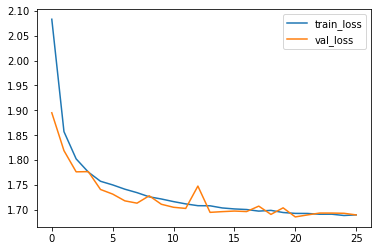

In [35]:
_ = log.plot()

In [36]:
class MnistSimInput(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        img = self.mnist_dataset[index][0]
        return img

In [37]:
dataset_test_x = MnistSimInput(mnist_test)
dl_test_x = DataLoader(dataset_test_x, batch_size, shuffle=False)

In [38]:
next(iter(dl_test_x)).shape

torch.Size([128, 1, 28, 28])

In [39]:
dl_test_x = tt.data.dataloader_input_only(dl_test)

In [40]:
next(iter(dl_test_x)).shape

torch.Size([128, 1, 28, 28])

In [41]:
surv = model.predict_surv_df(dl_test_x)

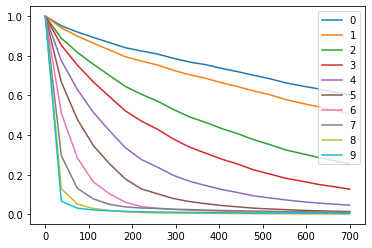

In [42]:
for i in range(10):
    idx = mnist_test.targets.numpy() == i
    surv.loc[:, idx].mean(axis=1).rename(i).plot()
_ = plt.legend()

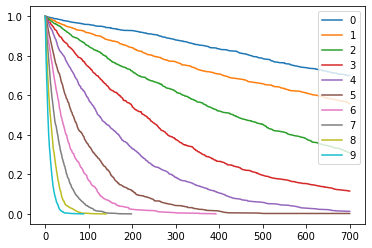

In [43]:
for i in range(10):
    idx = mnist_test.targets.numpy() == i
    kaplan_meier(*sim_test.iloc[idx]).rename(i).plot()
_ = plt.legend()

In [44]:
surv = model.interpolate(10).predict_surv_df(dl_test_x)

In [45]:
ev = EvalSurv(surv, *sim_test, 'km')

In [46]:
ev.concordance_td()

/home/liucj/github/TEP-prognosis/venv/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 7000. The TBB threading layer is disabled.
  warnings.warn(problem)


0.7197616320722958

In [47]:
time_grid = np.linspace(0, sim_test[0].max())
ev.integrated_brier_score(time_grid)

0.10474406149139236